In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, TargetEncoder
import category_encoders as ce 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("credit_data.csv")
df.head()

,default,account_check_status,duration_in_month,credit_history,purpose,credit_amount,savings,present_emp_since,installment_as_income_perc,personal_status_sex,...,present_res_since,property,age,other_installment_plans,housing,credits_this_bank,job,people_under_maintenance,telephone,foreign_worker
0,0,< 0 DM,6,critical account/ other credits existing (not ...,domestic appliances,1169,unknown/ no savings account,.. >= 7 years,4,male : single,...,4,real estate,67,none,own,2,skilled employee / official,1,"yes, registered under the customers name",yes
1,1,0 <= ... < 200 DM,48,existing credits paid back duly till now,domestic appliances,5951,... < 100 DM,1 <= ... < 4 years,2,female : divorced/separated/married,...,2,real estate,22,none,own,1,skilled employee / official,1,none,yes
2,0,no checking account,12,critical account/ other credits existing (not ...,(vacation - does not exist?),2096,... < 100 DM,4 <= ... < 7 years,2,male : single,...,3,real estate,49,none,own,1,unskilled - resident,2,none,yes
3,0,< 0 DM,42,existing credits paid back duly till now,radio/television,7882,... < 100 DM,4 <= ... < 7 years,2,male : single,...,4,if not A121 : building society savings agreeme...,45,none,for free,1,skilled employee / official,2,none,yes
4,1,< 0 DM,24,delay in paying off in the past,car (new),4870,... < 100 DM,1 <= ... < 4 years,3,male : single,...,4,unknown / no property,53,none,for free,2,skilled employee / official,2,none,yes


In [3]:
cat_cols = df.select_dtypes("O").columns
num_cols = [col for col in df.columns if col not in cat_cols and col != "default"]

In [4]:
#Category columns
cat_cols

Index(['account_check_status', 'credit_history', 'purpose', 'savings',
       'present_emp_since', 'personal_status_sex', 'other_debtors', 'property',
       'other_installment_plans', 'housing', 'job', 'telephone',
       'foreign_worker'],
      dtype='object')

In [5]:
# Numeric columns
num_cols

['duration_in_month',
 'credit_amount',
 'installment_as_income_perc',
 'present_res_since',
 'age',
 'credits_this_bank',
 'people_under_maintenance']

<Axes: xlabel='default'>

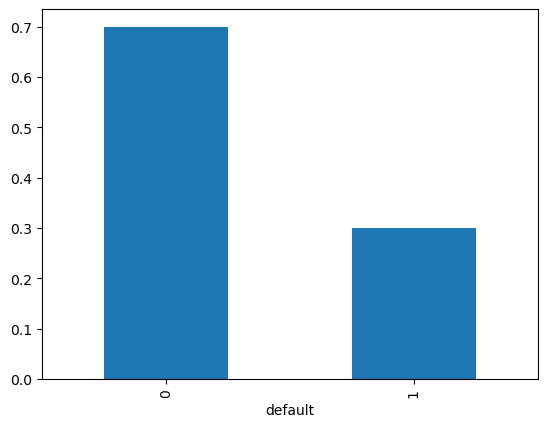

In [6]:
# Target distribution
df["default"].value_counts(normalize=True).plot.bar()

#### Dataset is imbalanced

Lets build a base model with Onehot encoding categorical variables and standard scaling the numeric columns

['duration_in_month', 'credit_amount', 'installment_as_income_perc', 'present_res_since', 'age', 'credits_this_bank', 'people_under_maintenance', 'default']


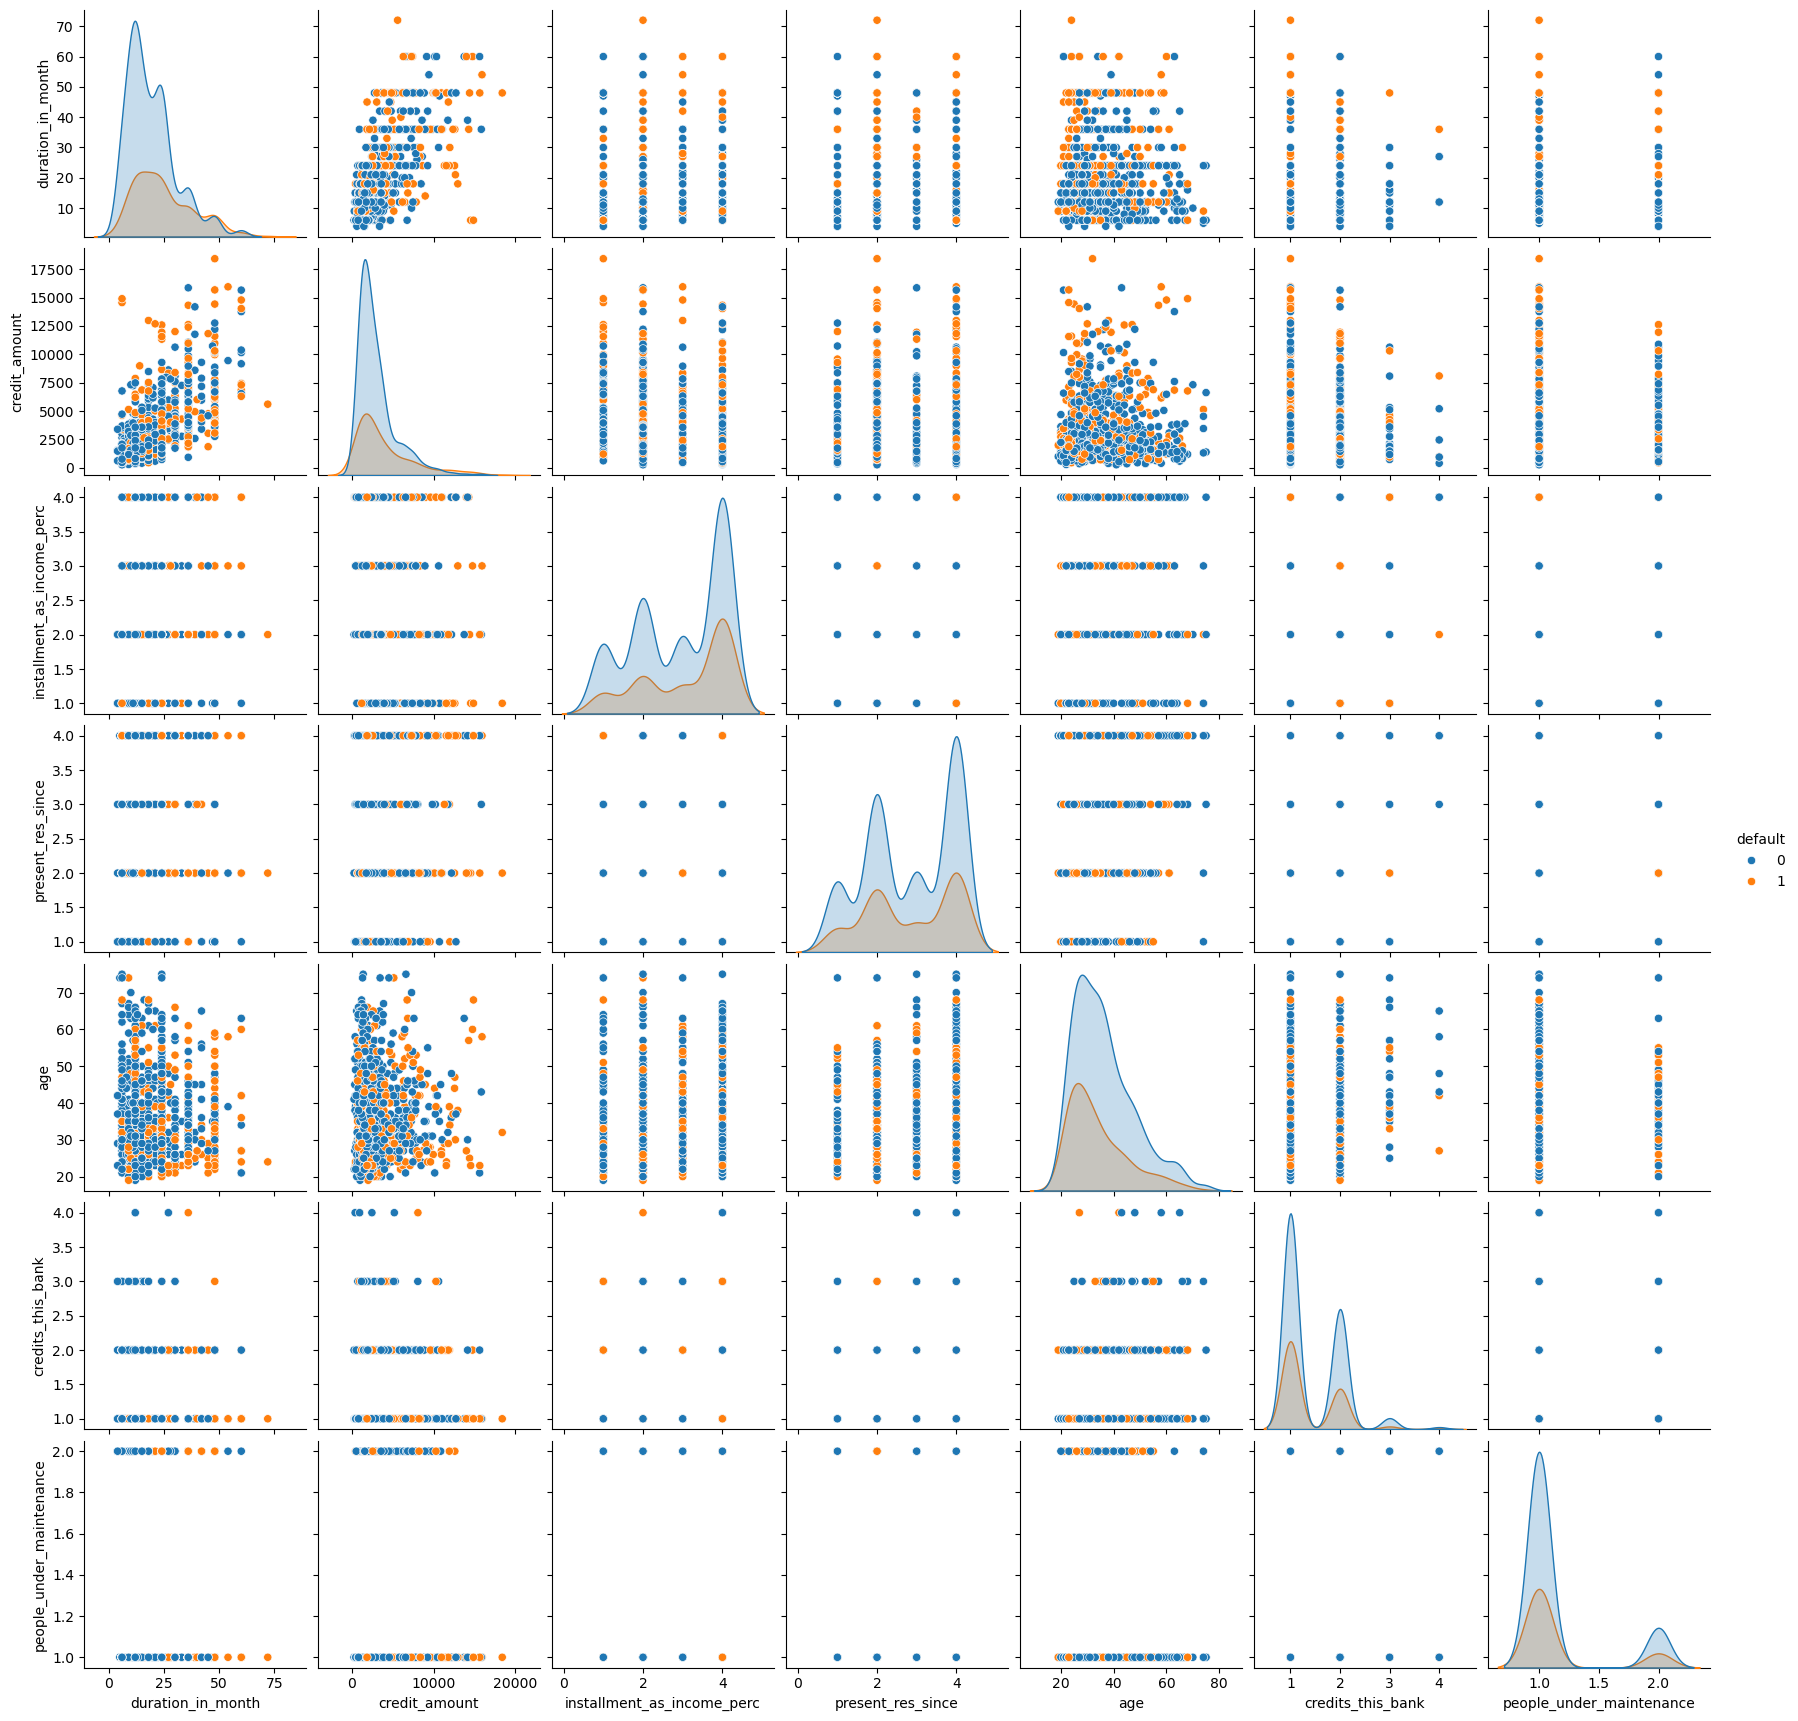

In [7]:
l2 = num_cols
l2.append("default")
print(l2)
sns.pairplot(df[l2], hue = "default")

<Axes: >

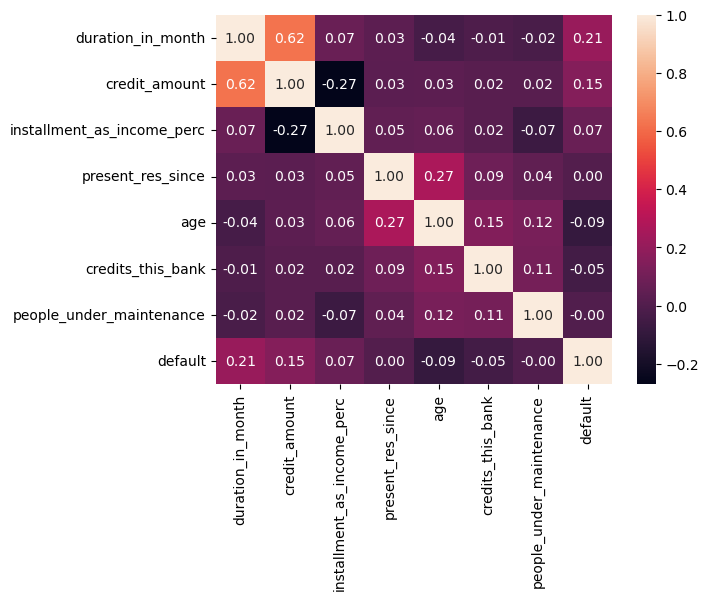

In [8]:
sns.heatmap(df[l2].corr(), annot= True, fmt = "0.2f")

In [9]:
## Since we are using Randomforest scaling is not required for numeric data.

In [10]:

X = df.drop("default", axis = 1)
y = df["default"]


In [11]:

from statsmodels.stats.outliers_influence import variance_inflation_factor

df_numeric = df.select_dtypes(include=['number']).drop("default", axis = 1)
def reduce_vif(df, threshold=5.0):
    """
    Simplified function to reduce multicollinearity in a DataFrame using VIF.
    
    Parameters:
        df (pd.DataFrame): Input DataFrame with numeric features.
        threshold (float): VIF threshold above which features are removed.

    Returns:
        pd.DataFrame: DataFrame with reduced multicollinearity.
    """
    while True:
        # Calculate VIF for all features
        vif = pd.DataFrame()
        vif["feature"] = df.columns
        vif["VIF"] = [variance_inflation_factor(df.values, i) for i in range(df.shape[1])]

        # Check if the max VIF exceeds the threshold
        max_vif = vif["VIF"].max()
        if max_vif > threshold:
            # Drop the feature with the highest VIF
            feature_to_drop = vif.loc[vif["VIF"].idxmax(), "feature"]
            print(f"Dropping '{feature_to_drop}' with VIF: {max_vif:.2f}")
            df = df.drop(columns=[feature_to_drop])
        else:
            break
    return df

# Example usage
# Assuming `df` is your DataFrame with numeric features
cleaned_df = reduce_vif(df_numeric, threshold=5.0)
X_encoded = X.drop(cleaned_df.columns, axis = 1)
cleaned_df.columns

Dropping 'age' with VIF: 10.93
Dropping 'people_under_maintenance' with VIF: 7.98
Dropping 'duration_in_month' with VIF: 7.32
Dropping 'present_res_since' with VIF: 6.09


Index(['credit_amount', 'installment_as_income_perc', 'credits_this_bank'], dtype='object')

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded,y, stratify= y, 
                                                    random_state = 42)

In [24]:
cat_cols = X_train.select_dtypes("O")
num_cols = [col for col in df.columns if col not in cat_cols and col != "default"]

In [36]:
from sklearn.model_selection import StratifiedKFold

def target_encoding_with_cv(X, y, cat_column, n_splits=5, min_samples=10, smoothing=1):
    global_mean = y.mean()
    encoding_map = {}
    skf = StratifiedKFold(n_splits=n_splits)

    for train_index, val_index in skf.split(X, y):
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        y_train, y_val = y.iloc[train_index], y.iloc[val_index]

        for category, group in X_train.groupby(cat_column):
            category_mean = y_train[group.index].mean()
            count = len(group)
            smooth_value = (count * category_mean + min_samples * global_mean) / (count + min_samples)
            encoding_map[category] = smooth_value

        # Apply the encoding to both training and validation sets
        X.iloc[train_index, X.columns.get_loc(cat_column)] = X_train[cat_column].map(encoding_map)
        X.iloc[val_index, X.columns.get_loc(cat_column)] = X_val[cat_column].map(encoding_map)

    return X[cat_column]

# Example usage
for cat_col in cat_cols:
    X_train[cat_col] = target_encoding_with_cv(X_train.copy(), y_train, cat_col, n_splits=3, min_samples=3, smoothing=1)
    X_test[cat_col] = target_encoding_with_cv(X_test.copy(), y_test, cat_col,min_samples=3, n_splits = 3, smoothing = 1)    
    # print(X_encoded_cv)


In [37]:
X_train.head()

,default,duration_in_month,credit_amount,installment_as_income_perc,present_res_since,age,credits_this_bank,people_under_maintenance,account_check_status_encoded,credit_history_encoded,...,savings_encoded,present_emp_since_encoded,personal_status_sex_encoded,other_debtors_encoded,property_encoded,other_installment_plans_encoded,housing_encoded,job_encoded,telephone_encoded,foreign_worker_encoded
350,0,9,1236,1,4,23,1,1,0.110169,0.323529,...,0.355556,0.414141,0.356383,0.289908,0.215470,0.255670,0.398058,0.279487,0.268293,0.297909
0,0,6,1169,4,4,67,2,1,0.473373,0.184358,...,0.142857,0.273973,0.270186,0.294872,0.200000,0.275934,0.265258,0.284238,0.298039,0.307826
637,0,60,15653,2,4,21,2,1,0.127119,0.345455,...,0.362857,0.206186,0.271875,0.293358,0.301587,0.266112,0.258824,0.287206,0.268595,0.305699
341,0,21,3599,1,4,26,1,1,0.470238,0.323529,...,0.355556,0.168317,0.356383,0.289908,0.282723,0.255670,0.398058,0.278689,0.302260,0.297909
626,0,6,2116,2,2,41,1,1,0.297297,0.318182,...,0.368272,0.271028,0.270186,0.294872,0.200000,0.275934,0.265258,0.284238,0.298039,0.307826


In [39]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit_transform(X_train)
scaler.transform(X_test)


array([[ 1.52752523,  2.29341769,  1.44709286, ..., -0.3103229 ,
         0.68979095,  0.19969836],
       [-0.65465367, -0.74243452, -0.34609884, ..., -0.3103229 ,
        -0.89087361,  0.19969836],
       [-0.65465367, -1.24840989, -0.94592887, ..., -0.55499756,
         0.68979095,  0.19969836],
       ...,
       [-0.65465367, -0.23645916,  0.07737597, ..., -0.3103229 ,
        -0.89087361,  0.19969836],
       [-0.65465367, -0.74243452, -0.53542135, ..., -0.55499756,
         0.68979095,  0.19969836],
       [-0.65465367,  1.53445463,  3.16655622, ..., -0.3103229 ,
        -0.89087361,  0.19969836]])

In [40]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred_prob = model.predict_proba(X_test)[:,1]
y_pred = model.predict(X_test)

# Evaluate the model
roc_auc = roc_auc_score(y_test, y_pred_prob)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

###Print
print("ROC: {} \n Recall : {} \n Precision : {} \n F1_score : {}".format(roc_auc, recall, precision, f1))

ROC: 1.0 
 Recall : 1.0 
 Precision : 1.0 
 F1_score : 1.0


In [41]:
from xgboost import XGBClassifier
xgb = XGBClassifier(random_state = 42)
xgb.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [42]:
y_pred = xgb.predict(X_test)
y_pred_prob = xgb.predict_proba(X_test)[:,1]

roc_auc = roc_auc_score(y_test,y_pred_prob)
recall = recall_score(y_test, y_pred)         # Use predictions
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print results
print(f"ROC AUC: {roc_auc:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")

ROC AUC: 1.0000
Recall: 1.0000
Precision: 1.0000
F1 Score: 1.0000
